First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 
from psisim import datadir
from psisim import spectrum
import psisim.nair as nair
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_10511/3990040308.py:10: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
path = '/Users/huihaoz/Downloads/psisim-kpic/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

In [3]:
filters

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [4]:
TMT = telescope.TMT(path=path)
TMT.airmass=1.2
TMT.water_vapor=1.5
TMT.seeing = TMT.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [5]:
#Initialize a modhis object and set the current filter
modhis = instrument.modhis(telescope=TMT)
modhis.set_current_filter("TwoMASS-H")

#Get the set of wavelengths based on the current instrument setup
wavelengths = np.arange(0.5,2.5,1e-3)*u.um #modhis.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
modhis.set_observing_mode(3600*4,1,'TwoMASS-H', wavelengths,mode="off-axis", vortex_charge=1) 

MODHIS is mostly untested at this point


/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:109: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")


In [6]:
modhis.current_filter

'TwoMASS-H'

## Generate some Spectra

We can now generate a host spectrum

In [7]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.5*u.dex(u.cm/ u.s**2),"StarTeff":3600*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0.001*u.km/u.s,
                    "StarVsini":0.001*u.km/u.s,
                    "StarLimbDarkening":0.001}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-H',17.0,filters,modhis.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=modhis.current_dwvs)


In [8]:
host_properties["StarTeff"]

<Quantity 3600. K>

In [9]:
f0 = spectrum.scale_stellar(17.0,'TwoMASS-H',3600*u.K)
coup, ho_str=modhis.pick_coupling(w=wavelengths,factor_0=f0,teff=3600*u.K)

Plot the Spectrum!

Text(0, 0.5, 'Spectrum [ph / (Angstrom cm2 s)]')

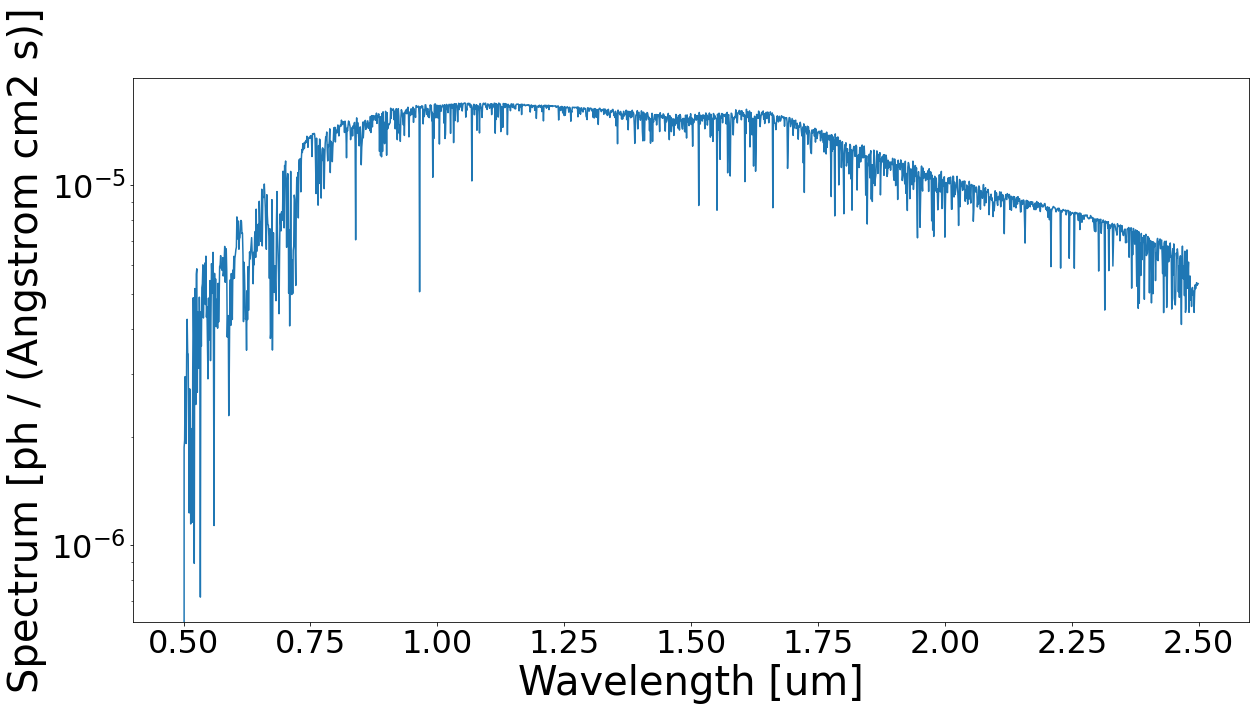

In [10]:
plt.figure(figsize=(20,10))

plt.semilogy(host_spectrum.wvs,host_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(host_spectrum.wvs.unit))
plt.ylabel("Spectrum [{}]".format(host_spectrum.spectrum.unit))

Now we can generate a target spectrum as well

In [11]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/ u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":20*u.km/u.s,"StarVsini":10*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',20,filters,modhis.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=modhis.current_dwvs)

(1e-10, 0.0001)

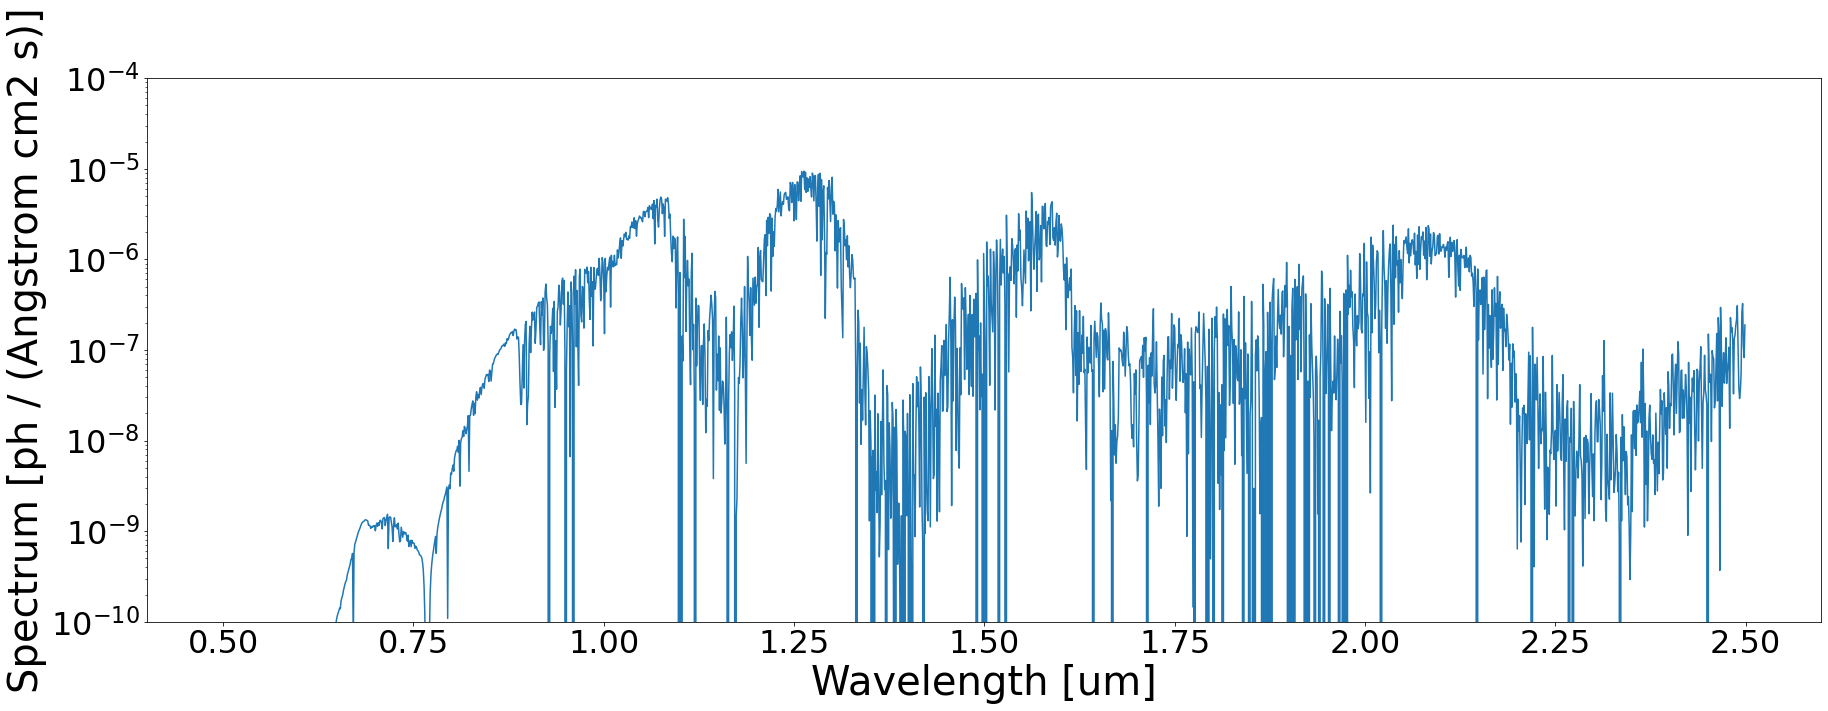

In [12]:
plt.figure(figsize=(30,10))

plt.semilogy(obj_spectrum.wvs,obj_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(obj_spectrum.wvs.unit))
plt.ylabel("Spectrum [{}]".format(obj_spectrum.spectrum.unit))
plt.ylim(1e-10,1e-4)

In [13]:
obj_spectrum.wvs,obj_spectrum.spectrum

(<Quantity [0.5  , 0.501, 0.502, ..., 2.497, 2.498, 2.499] um>,
 <Quantity [0.00000000e+00, 1.39077341e-12, 1.03483901e-12, ...,
            1.11011506e-07, 8.25302678e-08, 1.89124576e-07] ph / (Angstrom cm2 s)>)

### Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [14]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


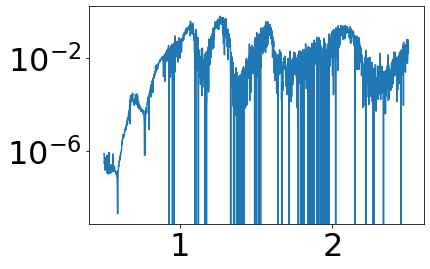

In [15]:
plt.semilogy(obj_spectrum.wvs,obj_spectrum.spectrum)

# Simulate an observation

First set some extra parameters

In [16]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[modhis.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
modhis.ao_mag = host_properties["StarAOmag"]

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

Actually simulate the observation 

In [17]:
f0

4.5901260739014926e-23

In [18]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(TMT,modhis,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/Users/huihaoz/Downloads/psisim-kpic/psisim/observation.py:410: RuntimeWarning: invalid value encountered in sqrt
  photon_noise = np.sqrt(detector_spectrum.decompose().value + thermal_spectrum.decompose().value + speckle_noise.decompose().value) * u.electron


Plot it!

Text(0, 0.5, 'Spectrum [electron um / micron]')

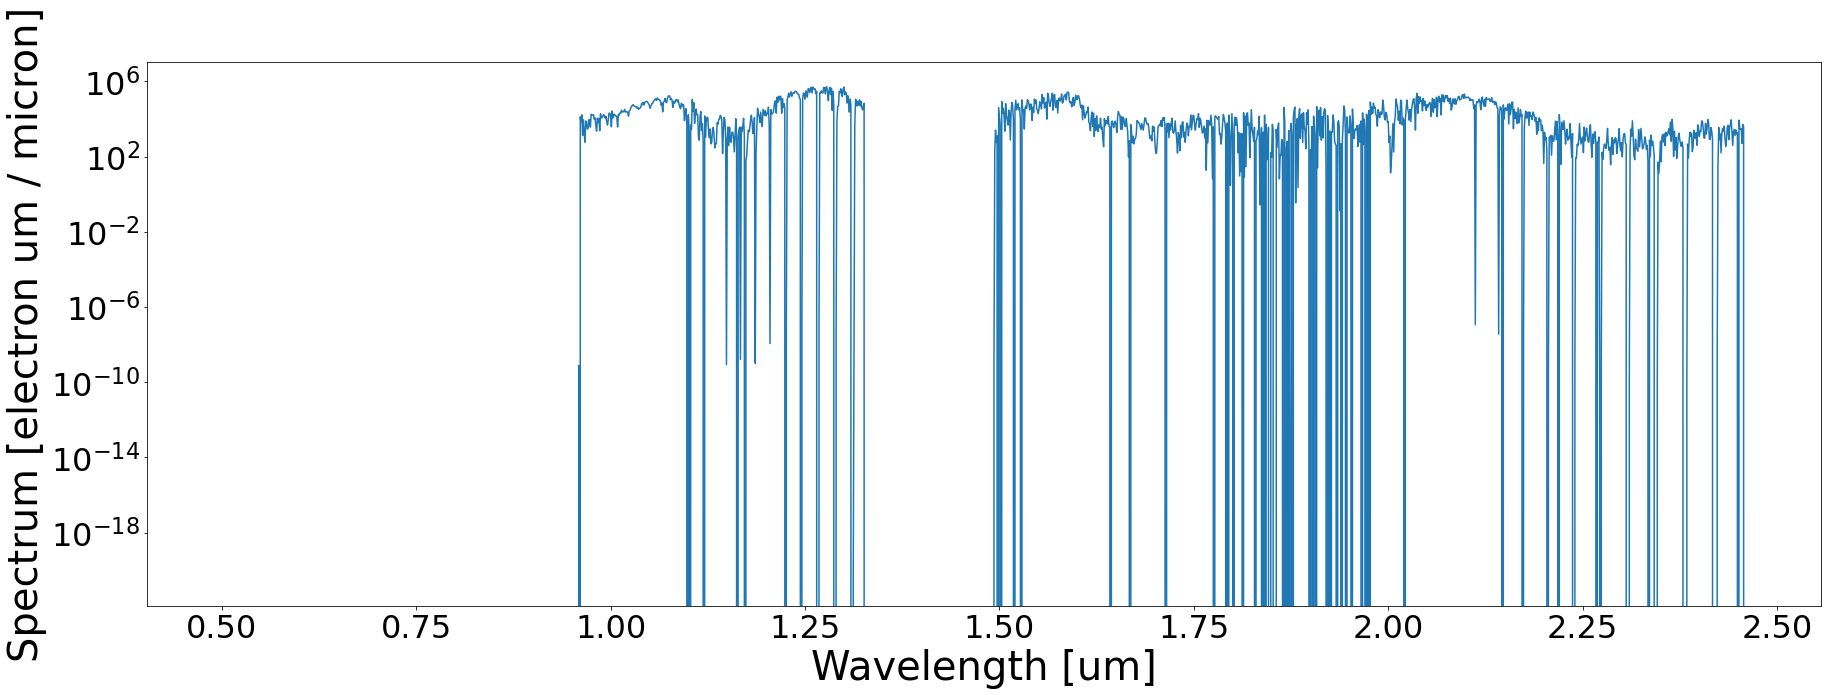

In [19]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)

---

In [20]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[modhis.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
modhis.ao_mag = host_properties["StarAOmag"]

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

In [21]:
zx,zc,zv,zt = observation.simulate_observation_singletarget(TMT, modhis, host_spectrum.wvs, host_spectrum.spectrum, host_properties, f0,inject_noise = False, sky_on = False, post_processing_gain = 1, return_noise_components = False,apply_lsf = False, integrate_delta_wv = False)

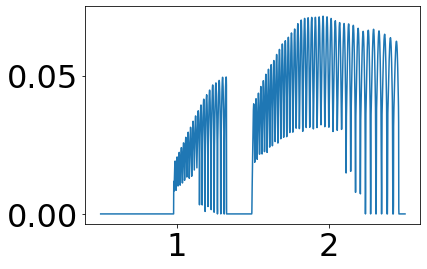

In [23]:
plt.plot( host_spectrum.wvs,zt)

In [31]:
host_spectrum.wvs

<Quantity [0.5  , 0.501, 0.502, ..., 2.497, 2.498, 2.499] um>

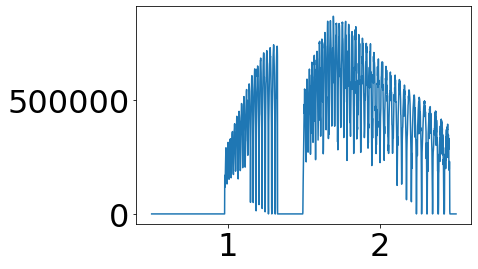

In [24]:
plt.plot( host_spectrum.wvs,zx)

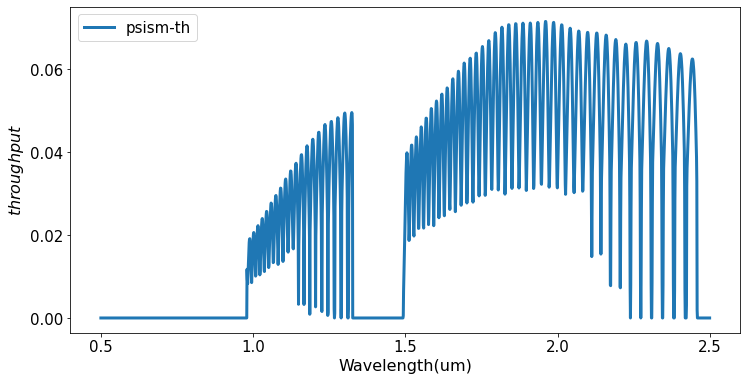

In [36]:
plt.figure(figsize=(12, 6))
#plt.plot(wl_um_check, tbd_tra1_erg_check/(1/ang2_1.to(u.steradian)),'-',color = '#1f77b4', label='Blackbody flux we simulated',linewidth=3)
#plt.plot(sim_x, sim_y,'o',color = '#ff7f0e', label ='Data come from SIMBAD')
plt.plot(host_spectrum.wvs,zt,linewidth=3,color = '#1f77b4' ,label='psism-th')
#plt.plot(so.inst.xtransmit/1000,so.inst.base_throughput * so.inst.coupling ,linewidth=3,color = 'red',label='specsim-th' )
plt.legend()
plt.xlabel("Wavelength(um)",fontdict={ 'size'   : 16})
plt.ylabel("$throughput$",fontdict={ 'size'   : 16})
#plt.xlim(0.9,5.6)
#plt.title("ELT-R150-TRA1")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 15})

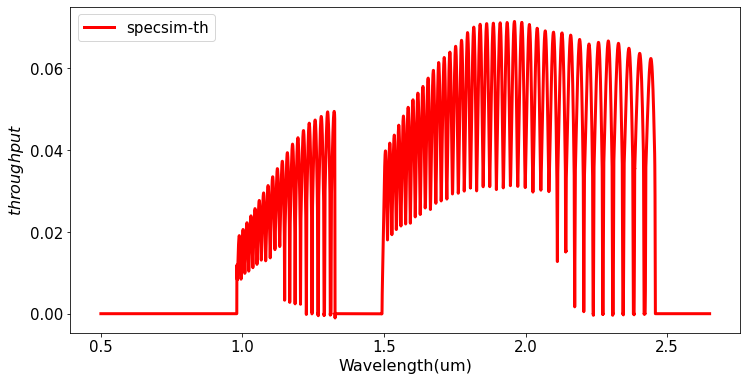

In [37]:
plt.figure(figsize=(12, 6))
#plt.plot(wl_um_check, tbd_tra1_erg_check/(1/ang2_1.to(u.steradian)),'-',color = '#1f77b4', label='Blackbody flux we simulated',linewidth=3)
#plt.plot(sim_x, sim_y,'o',color = '#ff7f0e', label ='Data come from SIMBAD')
#plt.plot(host_spectrum.wvs,zt,linewidth=3,color = '#1f77b4' ,label='psism-th')
plt.plot(so.inst.xtransmit/1000,so.inst.base_throughput * so.inst.coupling ,linewidth=3,color = 'red',label='specsim-th' )
plt.legend()
plt.xlabel("Wavelength(um)",fontdict={ 'size'   : 16})
plt.ylabel("$throughput$",fontdict={ 'size'   : 16})
#plt.xlim(0.9,5.6)
#plt.title("ELT-R150-TRA1")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 15})

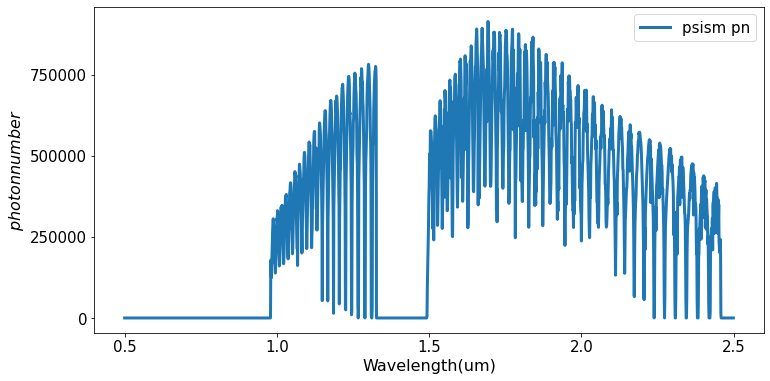

In [42]:
plt.figure(figsize=(12, 6))
#plt.plot(wl_um_check, tbd_tra1_erg_check/(1/ang2_1.to(u.steradian)),'-',color = '#1f77b4', label='Blackbody flux we simulated',linewidth=3)
#plt.plot(sim_x, sim_y,'o',color = '#ff7f0e', label ='Data come from SIMBAD')
plt.plot(host_spectrum.wvs,zx/0.95,linewidth=3,color = '#1f77b4' ,label='psism pn')
#plt.plot(so.inst.xtransmit/1000,so.inst.base_throughput * so.inst.coupling ,linewidth=3,color = 'red',label='specsim-th' )
plt.legend()
plt.xlabel("Wavelength(um)",fontdict={ 'size'   : 16})
plt.ylabel("$photon number$",fontdict={ 'size'   : 16})
#plt.xlim(0.9,5.6)
#plt.title("ELT-R150-TRA1")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 15})

In [46]:
savepath = './'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


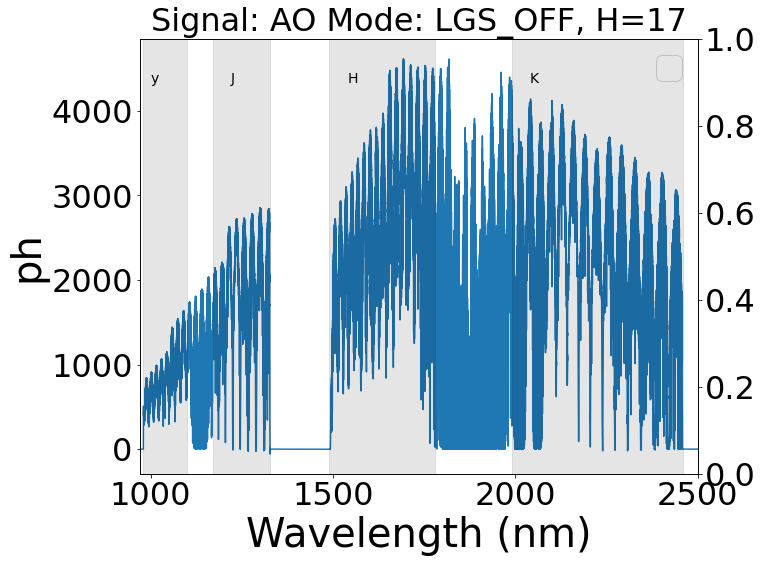

In [47]:
plot_tools.plot_photon(so,snrtype=0,savepath=savepath)